### **1. Import the Required Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from glob import glob
from tqdm import tqdm
from tensorflow.keras.models import *
import cv2
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint


from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Input,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam|
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.applications import MobileNetV2

### **2. Load the Image Training and Validation Datasets**

#### **i. Get the Image Dataset Paths**

In [ ]:
train_path = '/content/drive/MyDrive/pothole drone images/train'
test_path = '/content/drive/MyDrive/pothole drone images/test'

#### **ii. Load Image Datasets and Apply Augmentations**

Since the images present in the datasets are 150x150px in size, the image height and width are taken as 150, 150 respectively. The batch size value can be changed if required.

In [ ]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32
image_size = (128,128)

Loading the training dataset and applying augmentations on it.

In [ ]:
train_generator = ImageDataGenerator(
    rescale = 1.0/255.,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=(0.5, 1.5),
)
test_generator = ImageDataGenerator(rescale=1./255.)

Loading the validation dataset.

In [ ]:
train_datagen = train_generator.flow_from_directory(
    train_path,
    batch_size=10,
    target_size=(224, 224)
)
test_datagen = test_generator.flow_from_directory(
    test_path,
    batch_size=10,
    target_size=(224, 224)
)

Found 3793 images belonging to 2 classes.
Found 830 images belonging to 2 classes.


### **3. Training a mobilenetv2 Model**

Since the training dataset is ready let's create a simple mobilenetv2 Model to train on the image datasets

#### **i. Create a mobilenetv2 Build Model**

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model_mob = Model(inputs=base_model.input, outputs=predictions)

9406464/9406464 [==============================] - 0s 0us/step


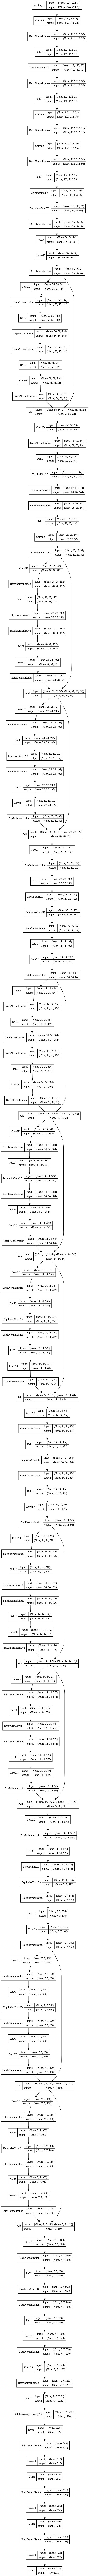

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_mob, expand_nested=True, show_shapes=True, show_layer_names=False)

#### Reduce Learning Rate on Plateau

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

#### **Compile the Model**

In [ ]:
model_mob.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### **Training the Model**

In [ ]:
hist_mob = model_mob.fit(train_datagen, epochs=10, validation_data=test_datagen,callbacks=[reduce_lr])

Epoch 1/10
380/380 [==============================] - 896s 2s/step - loss: 0.1417 - accuracy: 0.9594 - val_loss: 0.0551 - val_accuracy: 0.9783 - lr: 0.0010
Epoch 2/10
380/380 [==============================] - 287s 756ms/step - loss: 0.0751 - accuracy: 0.9815 - val_loss: 0.0469 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 3/10
380/380 [==============================] - 269s 707ms/step - loss: 0.0468 - accuracy: 0.9850 - val_loss: 0.0541 - val_accuracy: 0.9807 - lr: 0.0010
Epoch 4/10
380/380 [==============================] - 275s 724ms/step - loss: 0.0465 - accuracy: 0.9842 - val_loss: 0.0917 - val_accuracy: 0.9639 - lr: 0.0010
Epoch 5/10
380/380 [==============================] - 272s 715ms/step - loss: 0.0456 - accuracy: 0.9855 - val_loss: 0.0483 - val_accuracy: 0.9807 - lr: 0.0010
Epoch 6/10
380/380 [==============================] - 276s 727ms/step - loss: 0.0226 - accuracy: 0.9921 - val_loss: 0.0716 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 7/10
380/380 [=============================

### **5. Plotting the Model Metrics**

#### **i. Plotting training and validation accuracy, loss and learning rate**

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 3793 images belonging to 2 classes.


In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

In [ ]:
train_accuracy = hist_mob.history['accuracy']
val_accuracy = hist_mob.history['val_accuracy']

train_loss = hist_mob.history['loss']
val_loss = hist_mob.history['val_loss']

learning_rate = hist_mob.history['lr']

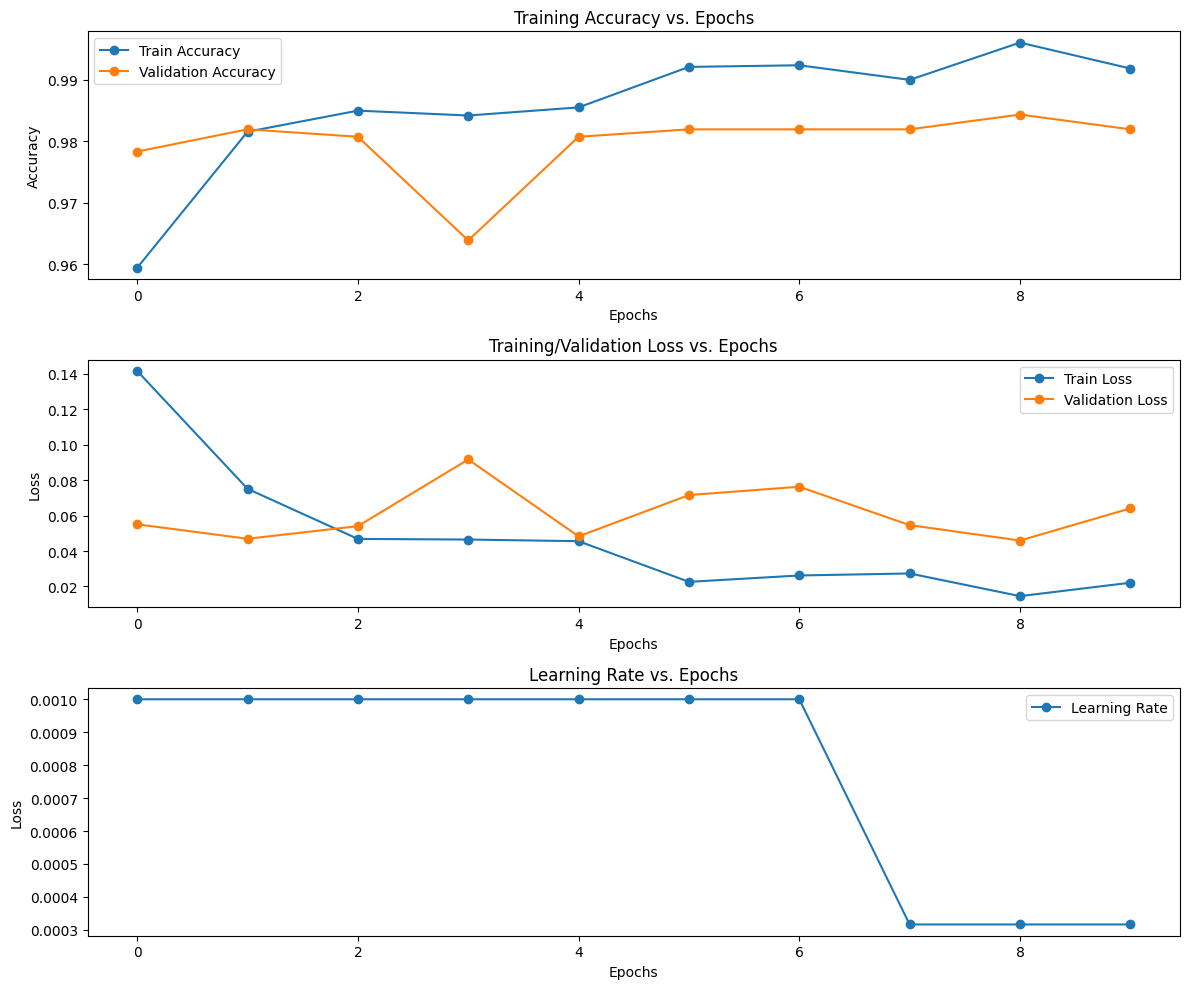

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

### **6. Testing the Model on Test Set**

Testing the model on the validation dataset because a seperate dataset for testing is not available.

In [ ]:
test_dataset = '/content/drive/MyDrive/pothole drone images/test'

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 830 images belonging to 2 classes.


### **7. Model Prediction on the Test Dataset**

In [ ]:
predictions = model_mob.predict(test_generator)

26/26 [==============================] - 23s 839ms/step


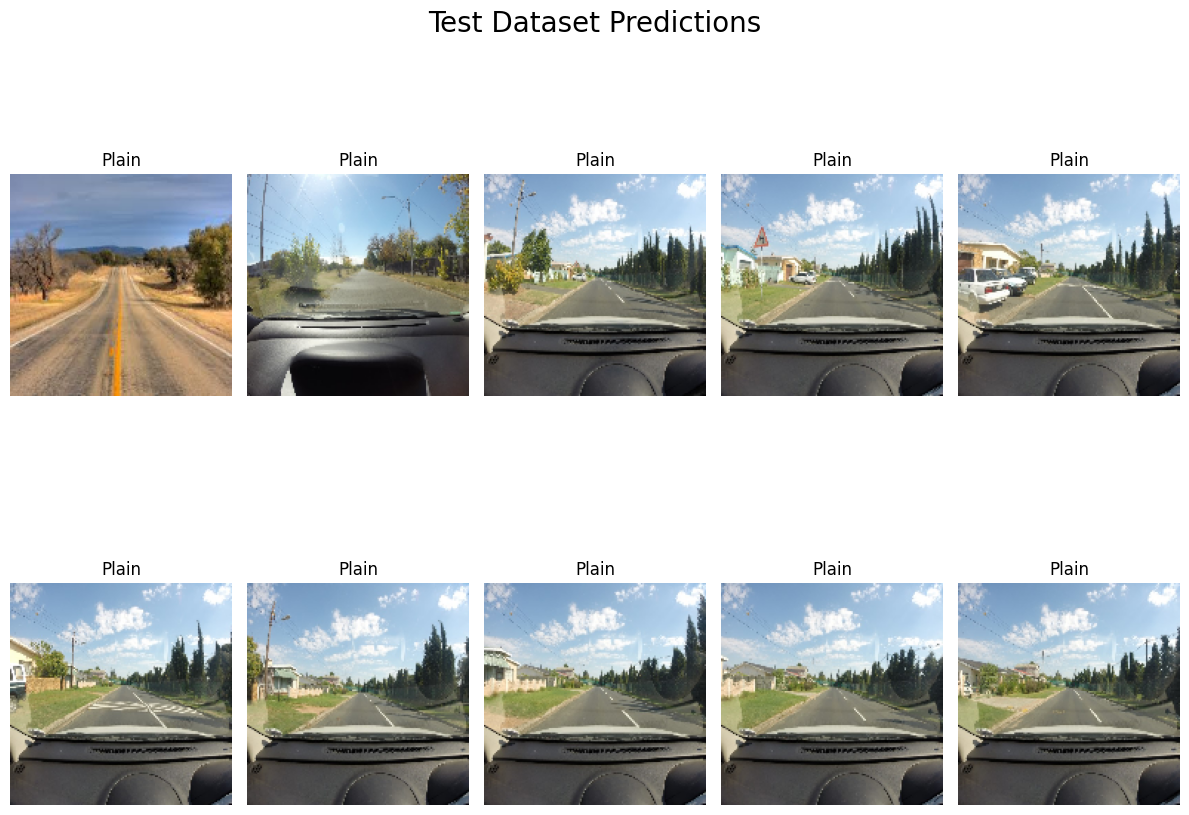

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
test_loss, test_accuracy = model_mob.evaluate(test_generator, batch_size=BATCH_SIZE)

26/26 [==============================] - 20s 759ms/step - loss: 0.0746 - accuracy: 0.9783


In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.07455021888017654
Test Accuracy: 0.9783132672309875


The test loss and test accuracy is the same as validation loss and validation accuracy at the last step since the testing and validation datasets are same.

### **8. Plotting the Classification Metrics**

### **i. Confusion Matrix**

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

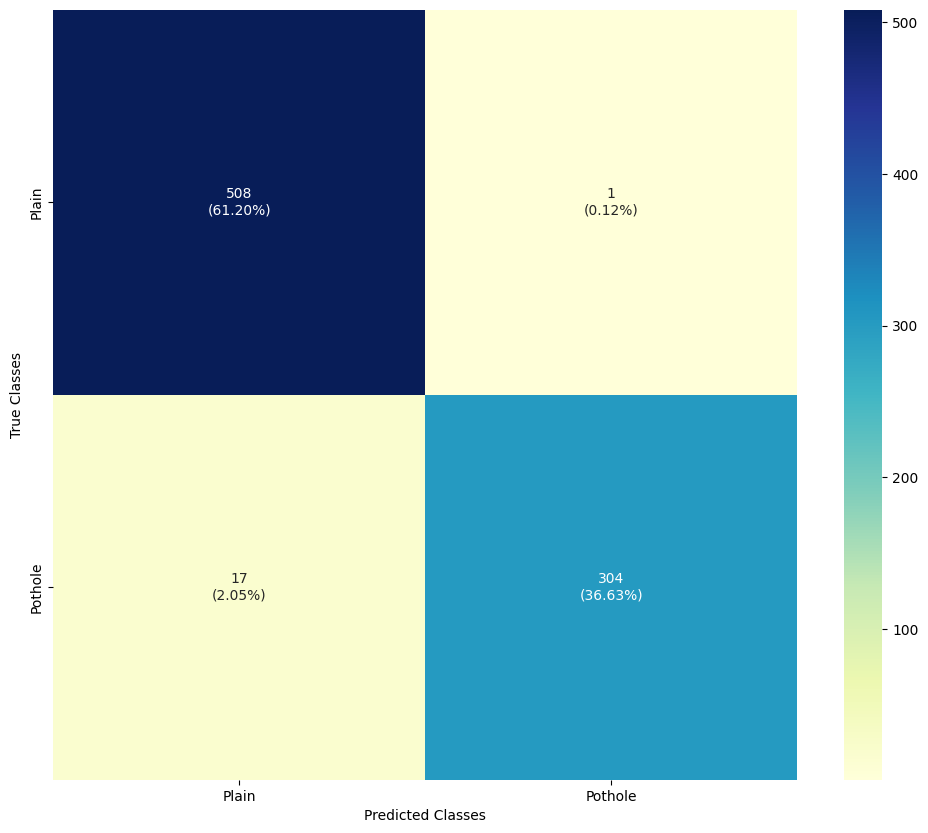

In [ ]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2, 2)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

       Plain       0.97      1.00      0.98       509
     Pothole       1.00      0.95      0.97       321

    accuracy                           0.98       830
   macro avg       0.98      0.97      0.98       830
weighted avg       0.98      0.98      0.98       830



### **9. Wrong Predictions**

Let's see where the model has given wrong predictions and what were the actual predictions on those images.

In [ ]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [ ]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

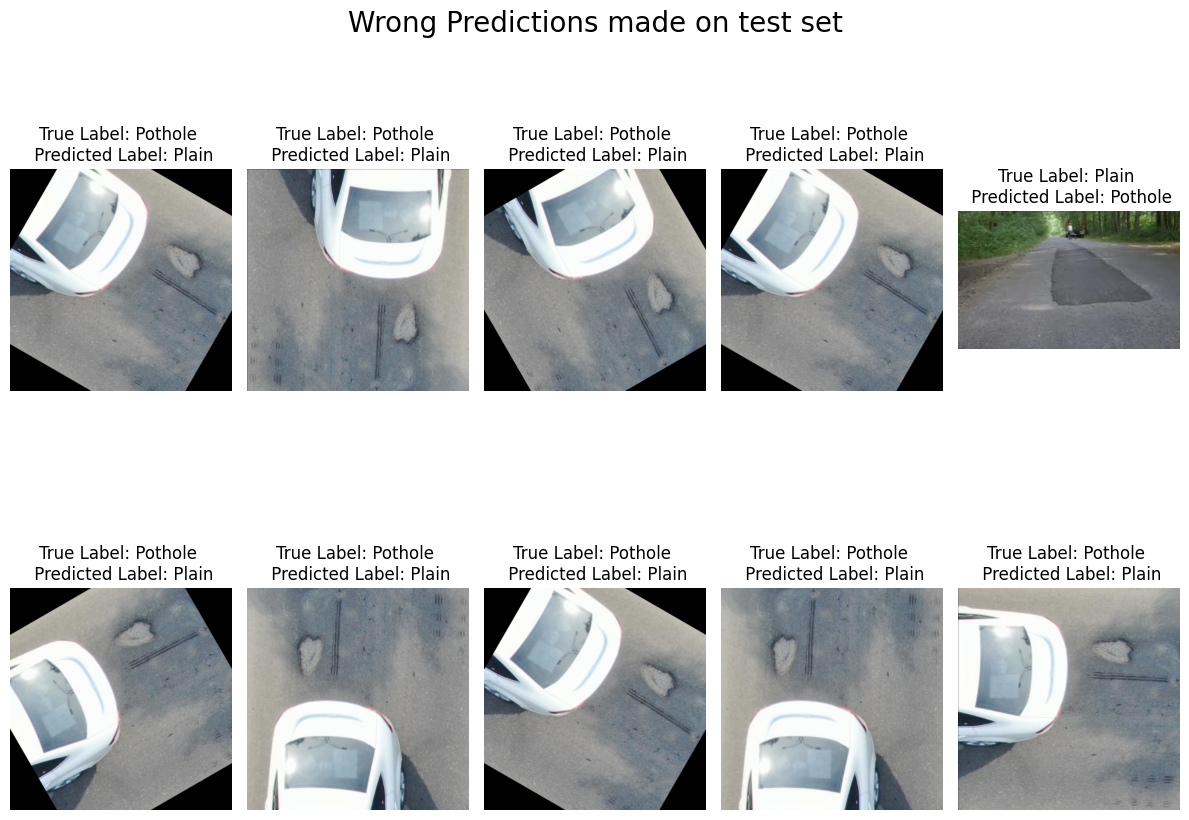

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

### **3.Segmentation Training Images**

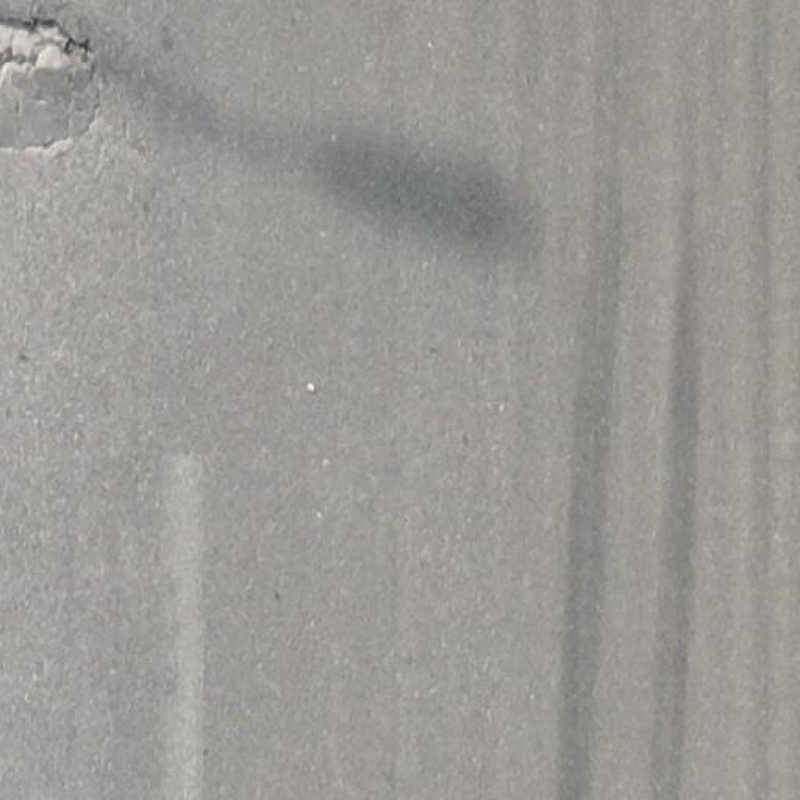

In [ ]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image
# Sample file out of the dataset
file_name = '/content/drive/MyDrive/pothole drone images/train/Pothole/China_Drone_001940_jpg.rf.9adf9149172df2914dcd0604ec92f23a_zooming_1.1.jpg'
img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

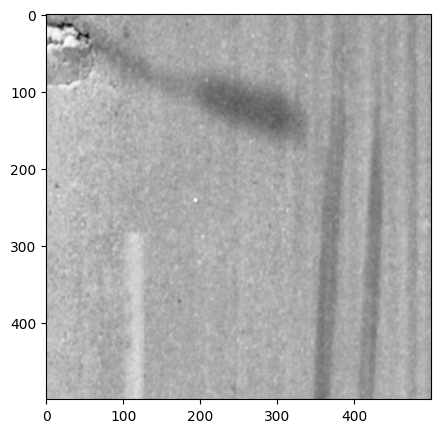

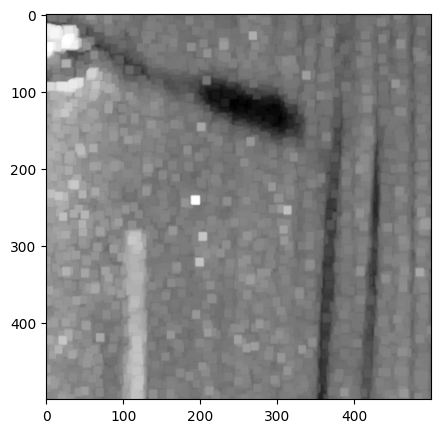

In [ ]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)


def plot_rgb(image):
    plt.figure(figsize=(5,5))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


def plot_gray(image):
    plt.figure(figsize=(5,5))
    return plt.imshow(image, cmap='Greys_r')

image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

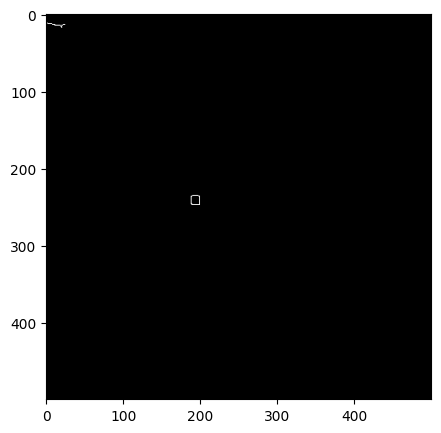

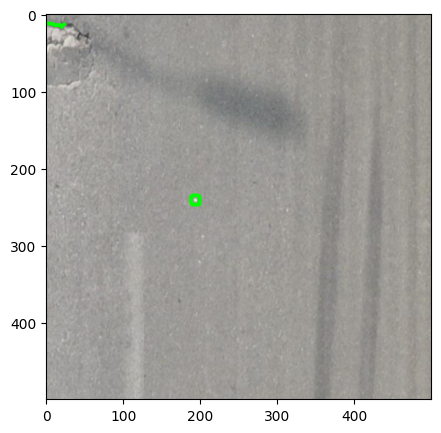

In [ ]:
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plot_gray(edged)

cv2.__version__

# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

In [ ]:
test_loss, test_accuracy = model_mob.evaluate(test_generator)
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

26/26 [==============================] - 28s 1s/step - loss: 0.0746 - accuracy: 0.9783
Test Loss:     0.07455021888017654
Test Accuracy: 0.9783132672309875
